# Programmatically load the data into your preferred analytical environment.


In [10]:
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the file path
file_path = 'TRDataChallenge2023.txt'

# Initialize counters and storage
document_count = 0
postures_count = 0
paragraph_count = 0
data = []
unique_labels = set()  # Set to track unique labels

# Load and process each line as a separate JSON object
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line as JSON
        document = json.loads(line.strip())
        
        # Increment document count
        document_count += 1
        
        # Count postures
        postures = document.get("postures", [])
        postures_count += len(postures)
        
        # Count paragraphs and aggregate text for model input
        document_text = ""
        for section in document.get("sections", []):
            paragraphs = section.get("paragraphs", [])
            paragraph_count += len(paragraphs)
            document_text += " ".join(paragraphs)  # Aggregate paragraphs into one string per document
        
        # Append data with document text and labels
        if postures:
            label = postures[0]  # Assuming first posture as label
            data.append((document_text, label))
            unique_labels.add(label)  # Add label to the set of unique labels

# Output data insights
print("Number of Documents:", document_count)
print("Number of Postures:", postures_count)
print("Number of Paragraphs:", paragraph_count)
print("Number of Unique Labels (Postures):", len(unique_labels))  # Count of unique labels

Number of Documents: 18000
Number of Postures: 27659
Number of Paragraphs: 542169
Number of Unique Labels (Postures): 194


# get unique label classes

In [11]:
NUM_CLASSES = len(unique_labels)
NUM_CLASSES

194

# Summarization frequency of labels

In [12]:
import pandas as pd
from collections import Counter 

# Calculate the distribution of each unique label
label_distribution = Counter(label for _, label in data)

# Create a DataFrame for better visualization
label_df = pd.DataFrame(label_distribution.items(), columns=['Label', 'Count'])
label_df = label_df.sort_values(by='Count', ascending=False).reset_index(drop=True)  # Sort by count

# Display the label distribution table
print("\nLabel Distribution (Sorted by Frequency):")
print(label_df)


Label Distribution (Sorted by Frequency):
                                             Label  Count
0                                        On Appeal   4942
1                                 Appellate Review   4652
2                                Motion to Dismiss   1449
3                Review of Administrative Decision   1395
4                       Motion for Attorney's Fees    609
..                                             ...    ...
189  Motion to Serve Additional Discovery Requests      1
190               Motion to Extend Claims Bar Date      1
191            Petition for Divorce or Dissolution      1
192        Declinatory Exception of Improper Venue      1
193              Motion to Vacate Summary Judgment      1

[194 rows x 2 columns]


- The top two labels, "On Appeal" (4942 instances) and "Appellate Review" (4652 instances), dominate the dataset. These labels represent common procedural postures in judicial opinions, which is expected given the nature of legal documents and the frequency of appeals in the legal process.

- Many labels (such as "Motion to Serve Additional Discovery Requests," "Petition for Divorce or Dissolution," and others) appear only once in the dataset. This indicates that these postures are rarely encountered, which poses challenges for any predictive modeling efforts.

- Challenges in Predicting Low-Frequency Labels: Predicting low-frequency labels presents several challenges: Insufficient Training Data, Models typically require a minimum number of examples to learn effectively. The imbalanced nature of the dataset can lead to model bias. For low-frequency labels, the model may memorize instances instead of generalizing patterns.


Classes Above Various Thresholds and Reserved Documents:
    Threshold N  Classes Above N  Documents Reserved Classes Reserved %  \
0             1              145               17028               74.7   
1             2              124               16986               63.9   
2             3              103               16923               53.1   
3             4               86               16855               44.3   
4             6               74               16792               38.1   
5             8               68               16749               35.1   
6            10               62               16693               32.0   
7            20               50               16515               25.8   
8            30               41               16293               21.1   
9            50               27               15742               13.9   
10          100               14               14797                7.2   
11         1000                4          

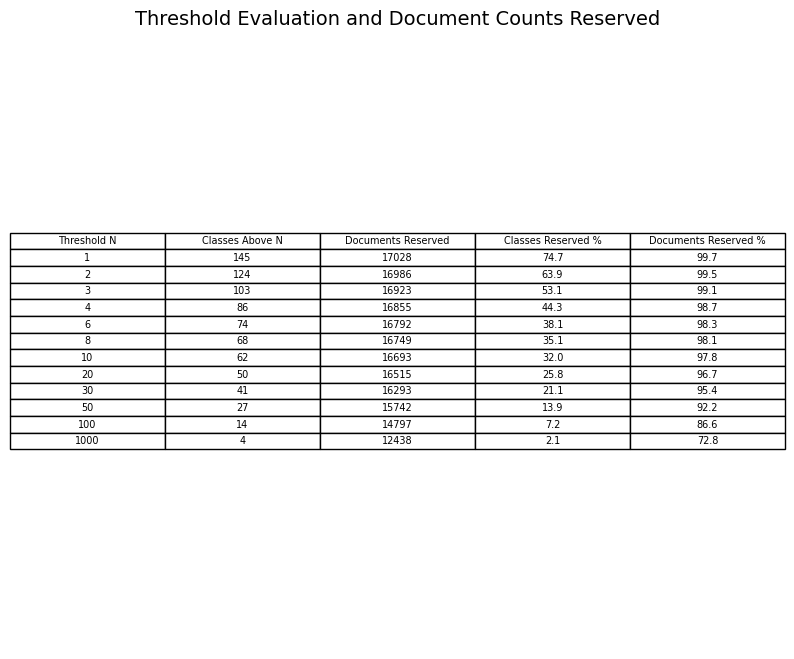

In [32]:
import json
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt

# Count occurrences of each label
label_distribution = Counter(label for _, label in data)

# Create a DataFrame for better visualization
label_df = pd.DataFrame(label_distribution.items(), columns=['Label', 'Count'])
label_df = label_df.sort_values(by='Count', ascending=False).reset_index(drop=True)  # Sort by count

# Evaluate counts above thresholds
thresholds = [1, 2, 3, 4, 6, 8, 10, 20, 30, 50, 100, 1000]
threshold_results = {n: (label_df['Count'] > n).sum() for n in thresholds}

# Calculate the number of documents reserved for each threshold
documents_reserved = {}
total_documents = len(data)  # Total number of documents in the dataset
total_classes = len(label_df)  # Total number of unique classes

for n in thresholds:
    labels_above_threshold = label_df[label_df['Count'] > n]['Label']
    documents_reserved[n] = sum(1 for _, label in data if label in labels_above_threshold.values)

# Calculate percentages
percentage_classes_reserved = {n: (threshold_results[n] / total_classes) * 100 for n in thresholds}
percentage_documents_reserved = {n: (documents_reserved[n] / total_documents) * 100 for n in thresholds}

# Format percentages to one decimal place
percentage_classes_reserved_formatted = {n: f"{percentage_classes_reserved[n]:.1f}" for n in thresholds}
percentage_documents_reserved_formatted = {n: f"{percentage_documents_reserved[n]:.1f}" for n in thresholds}

# Display threshold results in a DataFrame
threshold_df = pd.DataFrame(list(threshold_results.items()), columns=['Threshold N', 'Classes Above N'])
threshold_df['Documents Reserved'] = [documents_reserved[n] for n in thresholds]
threshold_df['Classes Reserved %'] = [percentage_classes_reserved_formatted[n] for n in thresholds]
threshold_df['Documents Reserved %'] = [percentage_documents_reserved_formatted[n] for n in thresholds]

# Display the final threshold DataFrame
print("\nClasses Above Various Thresholds and Reserved Documents:")
print(threshold_df)

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('tight')
ax.axis('off')
table_data = threshold_df.values
column_labels = threshold_df.columns

# Create a table plot
ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')
plt.title('Threshold Evaluation and Document Counts Reserved', fontsize=14)
plt.show()


Choosing a threshold N=20 for label frequency strikes a balance between retaining sufficient classes and minimizing noise in the model.

# Preprocess: Remove labels with low frequency in dataset

In [33]:
from collections import Counter

# Count occurrences of each label
label_counts = Counter(label for _, label in data)
print("Label Distribution:", label_counts)

# Initial count of data
before_count = len(data)
print(f"Count before removing labels with fewer than {min_instances} instances:", before_count)

# Set the minimum instances threshold
min_instances = 20

# Filter data based on the minimum instances
filtered_data = [(text, label) for text, label in data if label_counts[label] >= min_instances]

# Count after filtering
after_count = len(filtered_data)
print(f"Count after removing labels with fewer than {min_instances} instances:", after_count)

# Calculate and print the percentages
percentage_removed = ((before_count - after_count) / before_count) * 100
percentage_retained = (after_count / before_count) * 100

print(f"Percentage of data removed: {percentage_removed:.2f}%")
print(f"Percentage of data retained: {percentage_retained:.2f}%")

# Count the number of unique classes left after filtering
unique_classes_remaining = len(set(label for _, label in filtered_data))
print(f"Number of unique classes remaining after filtering: {unique_classes_remaining}")


Label Distribution: Counter({'On Appeal': 4942, 'Appellate Review': 4652, 'Motion to Dismiss': 1449, 'Review of Administrative Decision': 1395, "Motion for Attorney's Fees": 609, 'Motion for Preliminary Injunction': 340, 'Motion to Dismiss for Lack of Subject Matter Jurisdiction': 287, 'Motion to Compel Arbitration': 244, 'Motion for Judgment as a Matter of Law (JMOL)/Directed Verdict': 193, 'Motion for Reconsideration': 164, 'Motion to Dismiss for Lack of Personal Jurisdiction': 156, 'Motion for Default Judgment/Order of Default': 132, 'Motion for New Trial': 127, 'Motion to Dismiss for Lack of Standing': 107, 'Motion for Protective Order': 100, 'Motion for Permanent Injunction': 95, 'Motion for Contempt': 94, 'Motion to Dismiss for Lack of Jurisdiction': 93, 'Motion to Transfer or Change Venue': 76, 'Motion to Set Aside or Vacate': 74, 'Certified Question': 72, 'Sentencing or Penalty Phase Motion or Objection': 67, 'Motion for Costs': 57, 'Motion for Sanctions (Discovery)': 57, 'Moti

# train test split

In [37]:
# Prepare the data for training and testing after filtering
texts, labels = zip(*filtered_data)  # Unzip the text and labels
labels = list(labels)  # Convert to list for compatibility

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)
# Print the sizes of the datasets
print(f"Size of training dataset: {len(X_train)}")
print(f"Size of testing dataset: {len(X_test)}")
print(f"Total dataset size: {len(texts)}")

Size of training dataset: 13212
Size of testing dataset: 3303
Total dataset size: 16515


In [35]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [36]:
model = LogisticRegression(max_iter=10)  # Increase max_iter if needed
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Label Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/work/van-speech-nlp/jindaznb/slamenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Label Accuracy: 0.6010

Classification Report:
                                                                               precision    recall  f1-score   support

                                                            Appellate Review       0.83      0.97      0.90       930
                                     Application to Vacate Arbitration Award       0.00      0.00      0.00        11
                                                          Certified Question       0.00      0.00      0.00        14
                                             Juvenile Delinquency Proceeding       0.00      0.00      0.00         5
                                             Motion for Additional Discovery       0.00      0.00      0.00         4
                                                  Motion for Attorney's Fees       1.00      0.08      0.15       122
                                                         Motion for Contempt       0.00      0.00      0.00        19
       

/work/van-speech-nlp/jindaznb/slamenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/van-speech-nlp/jindaznb/slamenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/van-speech-nlp/jindaznb/slamenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

The analysis reveals that while the classification model achieves a 60.10% accuracy, its performance is compromised by significant challenges in predicting minority classes, indicating potential inadequacies for business objectives. To improve feasibility, it is recommended to address class imbalance through oversampling, undersampling, or synthetic data generation, optimize model parameters to enhance convergence, and consider alternative algorithms that may better handle such imbalances. Additionally, refining feature engineering, implementing k-fold cross-validation for reliable performance assessment, and maintaining a process of continuous monitoring and iteration will be crucial. These steps will help ensure the model becomes a robust tool that meets the business's classification needs effectively.